In [1]:
import pandas as pd
import altair as alt
import numpy as np

# Initial Beta Only

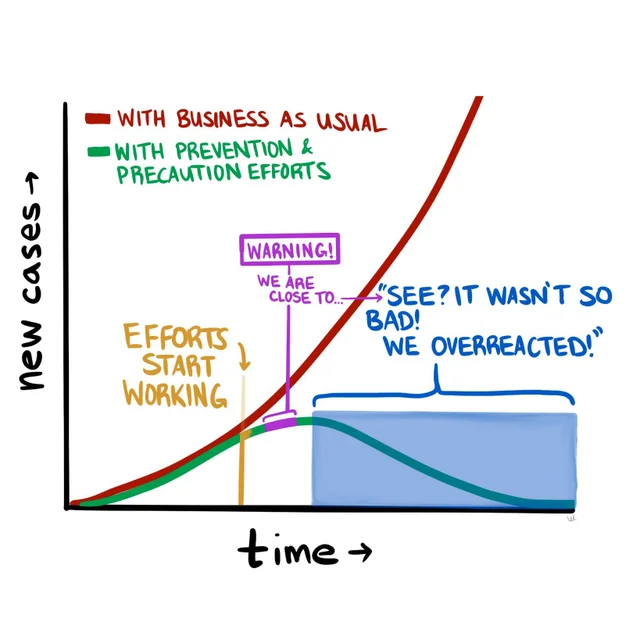

In [54]:
def run_sir_penn(beta, gamma, population, num_infected, N):
    i_n = num_infected
    s_n = population - i_n
    r_n = 0.
    inew_n = 1
    
    s_a, i_a, r_a, inew_a = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
    
    for index in range(N):
        s_a[index] = s_n
        i_a[index] = i_n
        r_a[index] = r_n
        inew_a[index] = inew_n

        s = s_n
        i = i_n
        r = r_n
        inew = inew_n
        
        s_n = (-beta * s * i) + s
        i_n = (beta * s * i - gamma * i) + i
        r_n = gamma * i + r
        inew_n = (beta * s * i)
    return s_a, i_a, r_a, inew_a

In [26]:
infectious_days = 14.
doubling_rate = 5
population = 1000000.
num_infected = 100.
N = 250

gamma = 1 / infectious_days
growth_rate = 2 ** (1 / doubling_rate) - 1
beta = (growth_rate + gamma) / (population - 1)

s, i, r, i_new = run_sir_penn(beta, gamma, population, num_infected, N)

In [27]:
d = pd.DataFrame({
    'day': np.arange(len(s)), 
    'susceptable': s, 
    "infected": i, 
    "recovered": r, 
    "new_infections": i_new, 
    "infections_cumulative": np.cumsum(i_new),
    "penn_ever_infected": i + r,
})

(alt
 .Chart(d)
 .transform_fold(['susceptable', 'infected', 'recovered', 'new_infections', 'infections_cumulative'])
 .encode(x='day:Q', y="value:Q", color='key:N')
 .mark_line()
)

alt.Chart(...)

In [28]:
def doubling_times(i):
    i_cumulative = np.cumsum(i)
    delta = np.diff(i_cumulative, 1)
    growth_rate = delta / i_cumulative[1:]
    return 1 / np.log2(growth_rate + 1)

In [29]:
d_times = doubling_times(i_new)
rate = np.diff(d_times, 1)
d_time = pd.DataFrame({
    'day': np.arange(len(s) - 2), 
    'doubling_time': d_times[:-1],
    'rate_of_increase': rate,
})

(alt
 .Chart(d_time.iloc[:100])
 .encode(x='day:Q', y='doubling_time:Q')
 .mark_line()
)

alt.Chart(...)

This plot shows that doubling time changes with time. No social mitigation is required. It will change differently if there is social mitigation. We need to be able to distinguish the change in doubling time due to each.

In [30]:
(alt
 .Chart(d_time.iloc[:40])
 .encode(x='day:Q', y='rate_of_increase:Q')
 .mark_line()
)

alt.Chart(...)

# Variable Beta

In [31]:
import numpy as np

def run_sir(beta, gamma, population, num_infected, N):
    i_n = num_infected
    s_n = population - i_n
    r_n = 0.
    inew_n = 1.
    
    s_a, i_a, r_a, inew_a = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
    
    for index in range(N):
        s_a[index] = s_n
        i_a[index] = i_n
        r_a[index] = r_n
        inew_a[index] = inew_n

        s = s_n
        i = i_n
        r = r_n
        inew = inew_n
        
        s_n = (-beta[index] * s * i) + s
        i_n = (beta[index] * s * i - gamma * i) + i
        r_n = gamma * i + r
        inew_n = (beta[index] * s * i)
    return s_a, i_a, r_a, inew_a

In [32]:
# Use variable doubling times
growth_rate = 2 ** (1 / d_times) - 1
beta_var = (growth_rate + gamma) / (population - 1)
s, i, r, i_new = run_sir(beta_var, gamma, population, num_infected, N - 1)

In [33]:
d = pd.DataFrame({
    'day': np.arange(len(s)), 
    'susceptable': s, 
    "infected": i, 
    "recovered": r, 
    "new_infections": i_new, 
    "infections_cumulative": np.cumsum(i_new),
    "penn_ever_infected": i + r,
})

(alt
 .Chart(d)
 .transform_fold(['susceptable', 'infected', 'recovered', 'new_infections', 'infections_cumulative'])
 .encode(x='day:Q', y="value:Q", color='key:N')
 .mark_line()
)

alt.Chart(...)

In [43]:
d_beta = pd.DataFrame({
    "day":d.day,
    "beta": beta,
    "beta_var": beta_var
})
(alt
 .Chart(d_beta[:])
 .transform_fold(["beta", "beta_var"])
 .encode(x='day:Q', y="value:Q", color='key:N')
 .mark_line()
)

alt.Chart(...)

Beta calculated using the changing doubling time. Beta describes contact rate between individuals.

# Try to Calculate Beta from Data

In [69]:
# la, nyc, slc county data from nytimes county level data
la = pd.read_csv("la_data.csv")
nyc = pd.read_csv("la_data.csv")
slc = pd.read_csv("la_data.csv")
la.date = pd.to_datetime(la.date)

In [74]:
# add admits to data for LA county.
la["admits"] = la.cases - la.cases.shift()
# Pretend customer gave us rows 60-65
la_train = la.iloc[0:]
la_train = la_train[["date", "cases", "admits"]]
# Use rows 66-end to project
la_test = la.iloc[66:]
la_test = la_test[["date", "cases", "admits"]]

In [167]:
gamma = 1/14
population = 10000000
la_train["growth_rate"] = la_train.admits / la_train.cases
la_train["beta"] = (la_train.growth_rate + gamma) / population
la_train["constant_beta"] = 2.2e-7 
la_train.iloc[30:60]

,date,cases,admits,growth_rate,beta,constant_beta
30,2020-02-25,1,0.0,0.000000,7.142857e-09,2.200000e-07
31,2020-02-26,1,0.0,0.000000,7.142857e-09,2.200000e-07
32,2020-02-27,1,0.0,0.000000,7.142857e-09,2.200000e-07
33,2020-02-28,1,0.0,0.000000,7.142857e-09,2.200000e-07
34,2020-02-29,1,0.0,0.000000,7.142857e-09,2.200000e-07
35,2020-03-01,1,0.0,0.000000,7.142857e-09,2.200000e-07
36,2020-03-02,1,0.0,0.000000,7.142857e-09,2.200000e-07
37,2020-03-03,1,0.0,0.000000,7.142857e-09,2.200000e-07
38,2020-03-04,7,6.0,0.857143,9.285714e-08,2.200000e-07
39,2020-03-05,11,4.0,0.363636,4.350649e-08,2.200000e-07


In [49]:

(alt
 .Chart(la_train.loc[la_train.cases > 10])
 .transform_fold(["beta", "constant_beta"])
 .encode(x='date:T', y="value:Q", color='key:N')
 .mark_line()
)

alt.Chart(...)

Beta vs. LA county data. Beta is calculated based on the growth rate, which is only valid in at time 0.

# Beta vs. initial doubling time

In [50]:
infectious_days = 14.
doubling_rate = np.arange(3, 10, .1)
population = 1000000.
num_infected = 10000.
N = 250

gamma = 1 / infectious_days
growth_rate = 2 ** (1 / doubling_rate) - 1
beta = (growth_rate + gamma) / (population - 1)
beta
df2 = pd.DataFrame({
    "initial_doubling": doubling_rate,
    "beta": beta,
    "real_beta": 2e-7,
})

(alt
 .Chart(df2)
 .transform_fold(["beta", "real_beta"])
 .encode(x='initial_doubling:Q', y="value:Q", color='key:N')
 .mark_line()
)

alt.Chart(...)

# Problem List:
We get data on number of cases and:
* could calculate initial beta and doubling time, as long as no social mitigation was in place.
* could calculate effect of social mitigation if onset and initial doubling time was known.

Either need: 
* **User to supply us with a reliable onset and initial doubling time**
* Or a way to estimate beta without using doubling time/growth rate
* Or need a way to differentiate increase in doubling time due to immunity (time) vs. mitigation.

# Try to fit SIR to the data
Start date and initial doubling rate are known. Might be able to use the early part of the curve to fit them.

### No social mitigation

In [298]:
infectious_days = 14.
doubling_rate = 3.
population = 1000000.
num_infected = 11
N = 300

gamma = 1 / infectious_days
growth_rate = 2 ** (1 / doubling_rate) - 1
beta0 = (growth_rate + gamma) / (population - 1)

beta = np.empty(N)
beta[:] = beta0

s, i, r, i_new = run_sir(beta, gamma, population, num_infected, N)
d = pd.DataFrame({
    'date': pd.date_range("2020-03-05", periods = N), 
    'susceptable': s, 
    "infected": i, 
    "recovered": r, 
    "new_infections": i_new, 
    "infections_cumulative": np.cumsum(i_new),
    "penn_ever_infected": i + r,
})

p1 = (alt
 .Chart(d)
 .transform_fold(['susceptable', 'infected', 'recovered', 'new_infections', 'infections_cumulative'])
 .encode(x='date:T', y="value:Q", color='key:N')
 .mark_line()
)
combined = d.merge(la_train, on="date", how="left")
combined = combined.rename(columns={"cases":"actual_infections_cumulative"})
combined["day"] = np.arange(0, combined.shape[0])

sir_p = (alt
 .Chart()
 .transform_fold(['infections_cumulative'])
 .encode(x='day:N', y=alt.Y("value:Q", scale = alt.Scale(domain=(0, 10000))), color='key:N')
 .mark_line(clip=True)
)

act_p = (alt
 .Chart()
 .transform_fold(['actual_infections_cumulative'])
 .encode(x='day:N', y="value:Q", color='key:N')
 .mark_line(point = True, clip=True)
)

p2 = alt.layer(sir_p, act_p, data=combined[:50]).resolve_scale(color="independent")
alt.hconcat(p1, p2)

alt.HConcatChart(...)

### Single social mitigation day with % effect

In [322]:
infectious_days = 14.
doubling_rate = 3.
population = 1000000.
num_infected = 11
N = 300

gamma = 1 / infectious_days
growth_rate = 2 ** (1 / doubling_rate) - 1
beta0 = (growth_rate + gamma) / (population - 1)

beta = np.empty(N)
beta[:] = beta0
change_points = [15] # which day?
change_quants = [1 - .3] # 30% reduction

beta[:change_points[0]] = beta0
for i in range(0, len(change_points)):
    old_beta = beta[change_points[i]-1]
    beta[change_points[i]:] = old_beta * change_quants[i]
    
    
s, i, r, i_new = run_sir(beta, gamma, population, num_infected, N)
d = pd.DataFrame({
    'date': pd.date_range("2020-03-05", periods = N), 
    'susceptable': s, 
    "infected": i, 
    "recovered": r, 
    "new_infections": i_new, 
    "infections_cumulative": np.cumsum(i_new),
    "penn_ever_infected": i + r,
})

p1 = (alt
 .Chart(d)
 .transform_fold(['susceptable', 'infected', 'recovered', 'new_infections', 'infections_cumulative'])
 .encode(x='date:T', y="value:Q", color='key:N')
 .mark_line()
)
combined = d.merge(la_train, on="date", how="left")
combined = combined.rename(columns={"cases":"actual_infections_cumulative"})
combined["day"] = np.arange(0, combined.shape[0])

sir_p = (alt
 .Chart()
 .transform_fold(['infections_cumulative'])
 .encode(x='day:N', y=alt.Y("value:Q", scale = alt.Scale(domain=(0, 1000000))), color='key:N')
 .mark_line(clip=True)
)

act_p = (alt
 .Chart()
 .transform_fold(['actual_infections_cumulative'])
 .encode(x='day:N', y="value:Q", color='key:N')
 .mark_line(point = True, clip=True)
)

p2 = alt.layer(sir_p, act_p, data=combined[:100]).resolve_scale(color="independent")
alt.hconcat(p1, p2)

alt.HConcatChart(...)

### Continuous social mitigation

In [316]:
infectious_days = 14.
doubling_rate = 3.
population = 1000000.
num_infected = 11
N = 300

gamma = 1 / infectious_days
growth_rate = 2 ** (1 / doubling_rate) - 1
beta0 = (growth_rate + gamma) / (population - 1)

beta = np.empty(N)
# change_points = [10,] # 21, 23, 27, 31]
# change_quants = [.9,] # .9, .9, .7, .7]

change_points = [6]
change_quants = [.9]

change_points = [6, 24]
change_quants = [.9, .8]
# 
change_points = [6, 24, 27]
change_quants = [.9, .8, .8]
# 
change_points = [6, 24, 27, 31]
change_quants = [.9, .8, .8, .6]

beta[:change_points[0]] = beta0
for i in range(0, len(change_points)):
    old_beta = beta[change_points[i]-1]
    beta[change_points[i]:] = old_beta * change_quants[i]

s, i, r, i_new = run_sir(beta, gamma, population, num_infected, N)
d = pd.DataFrame({
    'date': pd.date_range("2020-03-05", periods = N), 
    'susceptable': s, 
    "infected": i, 
    "recovered": r, 
    "new_infections": i_new, 
    "infections_cumulative": np.cumsum(i_new),
    "penn_ever_infected": i + r,
})

p1 = (alt
 .Chart(d)
 .transform_fold(['susceptable', 'infected', 'recovered', 'new_infections', 'infections_cumulative'])
 .encode(x='date:T', y="value:Q", color='key:N')
 .mark_line()
)
combined = d.merge(la_train, on="date", how="left")
combined = combined.rename(columns={"cases":"actual_infections_cumulative"})
combined["day"] = np.arange(0, combined.shape[0])

sir_p = (alt
 .Chart()
 .transform_fold(['infections_cumulative'])
 .encode(x='day:N', y=alt.Y("value:Q", scale = alt.Scale(domain=(0, 10000))), color='key:N')
 .mark_line(clip=True)
)

act_p = (alt
 .Chart()
 .transform_fold(['actual_infections_cumulative'])
 .encode(x='day:N', y="value:Q", color='key:N')
 .mark_line(point = True, clip=True)
)

p2 = alt.layer(sir_p, act_p, data=combined[:50]).resolve_scale(color="independent")
alt.hconcat(p1, p2)

alt.HConcatChart(...)

In [326]:
infectious_days = 14.
doubling_rate = 3.
population = 1000000.
num_infected = 11
N = 300

gamma = 1 / infectious_days
growth_rate = 2 ** (1 / doubling_rate) - 1
beta0 = (growth_rate + gamma) / (population - 1)

beta = np.empty(N)
# change_points = [10,] # 21, 23, 27, 31]
# change_quants = [.9,] # .9, .9, .7, .7]

change_points = [6]
change_quants = [.9]

change_points = [6, 24]
change_quants = [.9, .8]
# 
change_points = [6, 24, 27]
change_quants = [.9, .8, .8]
# 
change_points = [6, 24, 27, 31]
change_quants = [.9, .8, .8, .6]

beta[:change_points[0]] = beta0
for i in range(0, len(change_points)):
    old_beta = beta[change_points[i]-1]
    beta[change_points[i]:] = old_beta * change_quants[i]

s, i, r, i_new = run_sir(beta, gamma, population, num_infected, N)
d = pd.DataFrame({
    'date': pd.date_range("2020-03-05", periods = N), 
    'susceptable': s, 
    "infected": i, 
    "recovered": r, 
    "new_infections": i_new, 
    "infections_cumulative": np.cumsum(i_new),
    "penn_ever_infected": i + r,
})

p1 = (alt
 .Chart(d)
 .transform_fold(['susceptable', 'infected', 'recovered', 'new_infections', 'infections_cumulative'])
 .encode(x='date:T', y="value:Q", color='key:N')
 .mark_line()
)
combined = d.merge(la_train, on="date", how="left")
combined = combined.rename(columns={"cases":"actual_infections_cumulative"})
combined["day"] = np.arange(0, combined.shape[0])

sir_p = (alt
 .Chart()
 .transform_fold(['infections_cumulative'])
 .encode(x='day:N', y=alt.Y("value:Q", scale = alt.Scale(domain=(0, 1000000))), color='key:N')
 .mark_line(clip=True)
)

act_p = (alt
 .Chart()
 .transform_fold(['actual_infections_cumulative'])
 .encode(x='day:N', y="value:Q", color='key:N')
 .mark_line(point = True, clip=True)
)

p2 = alt.layer(sir_p, act_p, data=combined[:100]).resolve_scale(color="independent")
alt.hconcat(p1, p2)

alt.HConcatChart(...)

In [327]:
df3 = pd.DataFrame({
    "day": combined.day,
    "beta": beta
})
(alt
 .Chart(df3)
 .transform_fold(["beta"])
 .encode(x='day:N', y="value:Q", color='key:N')
 .mark_line()
)

alt.Chart(...)

In [332]:
.33 *(1 - .6)

0.132

In [ ]:
def fit_beta